# Introduction

In this project, we'll be answering some common business questions using SQL. The dataset we will be using is the Chinook database, which is available [here](https://github.com/lerocha/chinook-database). 

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. The schema diagram of the database tells us the available columns, the primary key of each of the tables highlighted in yellow and how each table relates to one another.

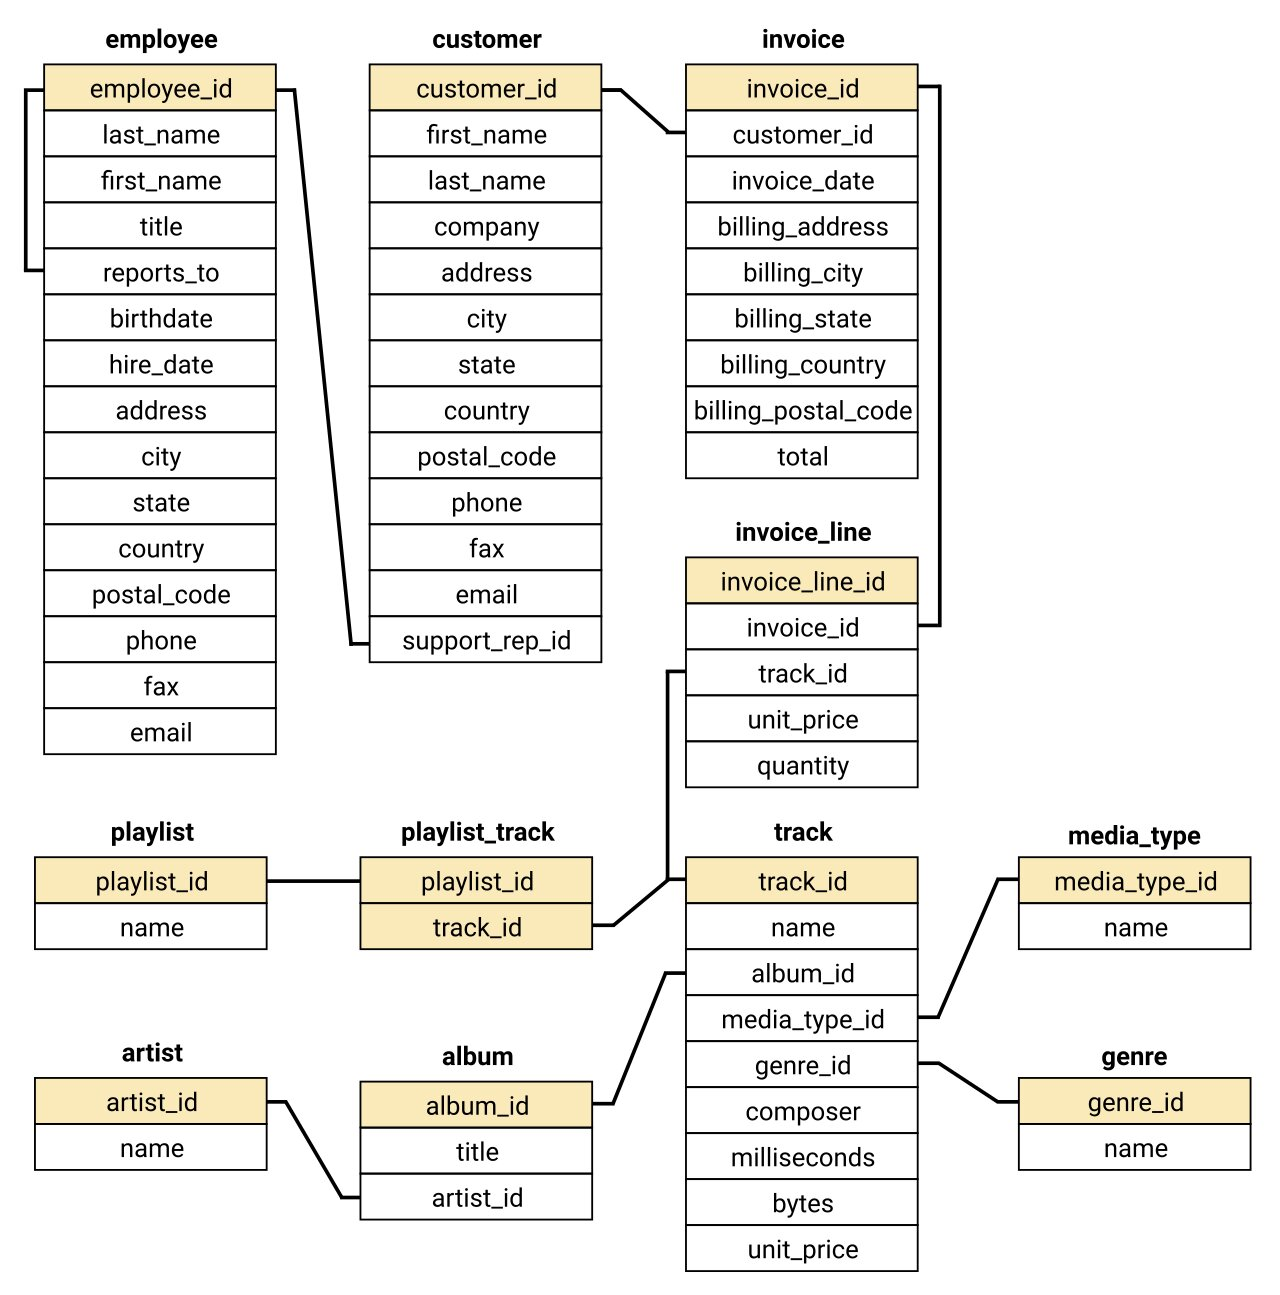

First we will connect our Jupyter Notebook to our database file.

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

## Overview of the Data

Next we will run a query to return information on the tables in the database.

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## Selecting Albums to Purchase

The first business question we are given is that we are to recommend three albums to add to the store, from a list of four. We are given the artist name and the genre of the album they produce:

| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

We are also told that record label specializes in artists from the USA. To answer this question we will write a query to generate a table returning the genre of music, with the total number of tracks sold in the USA both in absolute and as a percentage.

In [3]:
%%sql
SELECT 
    g.name genre, 
    SUM(il.quantity) total_sold_number,
    ROUND(100 * CAST(SUM(il.quantity) AS FLOAT) / (SELECT 
                                                       SUM(quantity) 
                                                   FROM invoice_line 
                                                   LEFT JOIN invoice ON invoice.invoice_id = invoice_line.invoice_id
                                                   WHERE invoice.billing_country = 'USA'),2) total_sold_percent
FROM genre g
LEFT JOIN track t ON t.genre_id = g.genre_id
LEFT JOIN invoice_line il ON il.track_id = t.track_id
LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
WHERE i.billing_country = 'USA'
GROUP BY genre
ORDER BY total_sold_number DESC;

 * sqlite:///chinook.db
Done.


genre,total_sold_number,total_sold_percent
Rock,561,53.38
Alternative & Punk,130,12.37
Metal,124,11.8
R&B/Soul,53,5.04
Blues,36,3.43
Alternative,35,3.33
Pop,22,2.09
Latin,22,2.09
Hip Hop/Rap,20,1.9
Jazz,14,1.33


Out of the available genres, the most sold genre is Punk, followed by Blues, followed by Pop, with Hip-Hop falling in last place. Based on the data, our recommendations would be to purchase the album from the artist Red Tone, then Slim Jim Bites and Meteor and the Girls in that order.

## Analysing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We are asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing better or worse than others.

To perform this analysis, we will write a query to return the total dollar sales for each agent. We will also include the employee title, their date they were hired, number of sales, average dollar per sale, track sold and average tracks per sale to assist with our analysis.

In [4]:
%%sql
SELECT 
    e.first_name || ' ' || e.last_name employee_name,
    e.title employee_title,
    e.hire_date date_hired,
    ROUND(SUM(i.total),2) total_sales,
    COUNT(DISTINCT i.invoice_id) number_sales,
    ROUND(CAST(SUM(i.total) AS FLOAT) / COUNT(DISTINCT i.invoice_id),2) avg_dollar_per_sale,
    SUM(il.quantity) tracks_sold,
    ROUND(CAST(SUM(il.quantity) AS FLOAT) / COUNT(DISTINCT i.invoice_id),2) avg_track_per_sale
FROM employee e
LEFT JOIN customer c ON c.support_rep_id = e.employee_id
LEFT JOIN invoice i ON i.customer_id = c.customer_id
LEFT JOIN invoice_line il ON il.invoice_id = i.invoice_id
GROUP BY employee_name
ORDER BY total_sales DESC;

 * sqlite:///chinook.db
Done.


employee_name,employee_title,date_hired,total_sales,number_sales,avg_dollar_per_sale,tracks_sold,avg_track_per_sale
Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,18246.69,212,86.07,1749,8.25
Margaret Park,Sales Support Agent,2017-05-03 00:00:00,15923.16,214,74.41,1600,7.48
Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,13333.32,188,70.92,1408,7.49
Robert King,IT Staff,2017-01-02 00:00:00,None,0,None,None,None
Nancy Edwards,Sales Manager,2016-05-01 00:00:00,None,0,None,None,None
Michael Mitchell,IT Manager,2016-10-17 00:00:00,None,0,None,None,None
Laura Callahan,IT Staff,2017-03-04 00:00:00,None,0,None,None,None
Andrew Adams,General Manager,2016-08-14 00:00:00,None,0,None,None,None


The first observation that stands out is that only 3 out of the 8 agents contributed to salse. The title of all these agents are Sales Support Agents. This is unsurprising as it is the job of the sale support agent to make sales, while other agents work on other parts of the business.

There is a discrepancy between each of the Sales Support Agents in terms of total dollar of sales, however each agent were hired at different times. It would make sense that the sales agent who had the longest tenure would have the highest sales figures, the data supports this with the total dollar of sales correlating with the tenure length. 

What is interesting is that number of sales does not follow the pattern in total_sales, with Margaret Park having a higher volume of sales than Jane Peacock, while the total tracks sold does follow the pattern total_sales. This suggests that while Maragaret is able to make more sales, each sale yields a lower number of tracks which means a lower average dollar per sale, therefore despite earning more sales her total_sales is lower.

## Analysing Sales by Country

Our next task is to analyse sales data for customer from each different country. The requirement is that sales that only has one customer is to be grouped as "Other" in our analysis and that category is to be forced to the bottom of the table.

We will approach this query by first writing a sub-query to categorise each country as either itself or "Other" if it only has one customer. Within that subquery, we will also create another column 'sort' which takes the value of 1 in the case it is 'Other' otherwise it will take a value of 0. We can sort using this column as a primary criteria to force the "Other" row to the bottom of the resulting table.

We will join the table created in the sub-query to the main query, so that the main query has access to the column which categorises each country as either itself or Other as well as the sorting column. Lastly we will GROUP BY the categorised country, and then group by the sorting column then the total_sales_value.

In [5]:
%%sql
WITH country_categories AS(
    SELECT 
        c.country country, 
        COUNT(country) count, 
        CASE
            WHEN COUNT(country) = 1 THEN 'Other'
            ELSE c.country
        END AS country_category,
        CASE
            WHEN COUNT(country) = 1 THEN 1
            ELSE 0
        END AS sort
    FROM customer c
    GROUP BY country
    ORDER BY country
)

SELECT 
    cc.country_category country,
    COUNT(DISTINCT c.customer_id) total_customers,
    COUNT(DISTINCT i.invoice_id) num_orders,
    ROUND(SUM(total),2) total_sales_value,
    ROUND(SUM(total) / COUNT(DISTINCT c.customer_id),2) avg_sales_per_customer,
    ROUND(SUM(total) / COUNT(DISTINCT i.invoice_id),2) avg_order_value
FROM customer c
LEFT JOIN invoice i ON i.customer_id = c.customer_id
LEFT JOIN country_categories cc ON c.country = cc.country
GROUP BY cc.country_category
ORDER BY cc.sort ASC, total_sales_value DESC;

 * sqlite:///chinook.db
Done.


country,total_customers,num_orders,total_sales_value,avg_sales_per_customer,avg_order_value
USA,13,131,1040.49,80.04,7.94
Canada,8,76,535.59,66.95,7.05
Brazil,5,61,427.68,85.54,7.01
France,5,50,389.07,77.81,7.78
Germany,4,41,334.62,83.66,8.16
Czech Republic,2,30,273.24,136.62,9.11
United Kingdom,3,28,245.52,81.84,8.77
Portugal,2,29,185.13,92.57,6.38
India,2,21,183.15,91.57,8.72
Other,15,147,1094.94,73.0,7.45


The single country that had the most sales is USA and it is far ahead of the runner up Canada. However, the combined sales of countries categorised as "Other" overtakes USA in terms of total_sales_value by a small margin.

## Album vs. Individual Tracks

Currently, the Chinook store is setup in a way that allows customers to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

The first step is to write a sub-query to categorise each invoice as either an album purchase or a track purchase. Since we are told customers don't often manually select every track from an album then add a few individual tracks from other albums to their purchase, we can make the assumption that if a purchase contains **exactly** the tracks from an entire album then it is an album purchase.

Then we calculate the summary statistic of the album purchase column for, the number of invoices and the percentage of invoices, to help us make a recommendation on whether Chinook should continue buying full albums from record companies. 

In [6]:
%%sql
WITH inv_album_purchase AS (
SELECT 
    i.invoice_id,
    t.album_id,
    CASE WHEN
        (
        (
        SELECT track.track_id FROM invoice
        LEFT JOIN invoice_line ON invoice_line.invoice_id = invoice.invoice_id
        LEFT JOIN track on track.track_id = invoice_line.track_id
        WHERE track.album_id = t.album_id
        
        EXCEPT
        
        SELECT track_id FROM track
        WHERE album_id = t.album_id
        ) IS NULL

        AND

        (
        SELECT track_id FROM track
        WHERE album_id = t.album_id

        EXCEPT

        SELECT track.track_id FROM invoice
        LEFT JOIN invoice_line ON invoice_line.invoice_id = invoice.invoice_id
        LEFT JOIN track on track.track_id = invoice_line.track_id
        WHERE track.album_id = t.album_id
        ) IS NULL
        ) = 1 THEN 'Album Purhcase'
        ELSE 'Track Purchase'
        END AS album_purchase
FROM invoice i
LEFT JOIN invoice_line il ON il.invoice_id = i.invoice_id
LEFT JOIN track t on t.track_id = il.track_id
GROUP BY i.invoice_id
)

SELECT 
    album_purchase purchase_type,
    COUNT(album_purchase) number_of_invoices,
    ROUND(100 * CAST(COUNT(album_purchase) AS FLOAT) / (SELECT COUNT(*) FROM inv_album_purchase),2) percentage_of_invoice
FROM inv_album_purchase
GROUP BY album_purchase;

 * sqlite:///chinook.db
Done.


purchase_type,number_of_invoices,percentage_of_invoice
Album Purhcase,458,74.59
Track Purchase,156,25.41


An overwhelming majority number of purchases consists of album purchases. Therefore, we recommend to continue buying full albums from record companies.